<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center>Assignment #7. Principal Component Analysis and Clustering</center>

In this assignment, we are going to walk through `sklearn` built-in implementations of dimensionality reduction and clustering methods. Answers should be submitted using [this web-form](https://goo.gl/forms/oPqLDP8nn9gSelSN2).

## 1. Principal Component Analysis

First import all required modules:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='white')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.model_selection import train_test_split

Use given toy data set:

In [2]:
X = np.array([[2., 13.], [1., 3.], [6., 19.],
              [7., 18.], [5., 17.], [4., 9.],
              [5., 22.], [6., 11.], [8., 25.]])

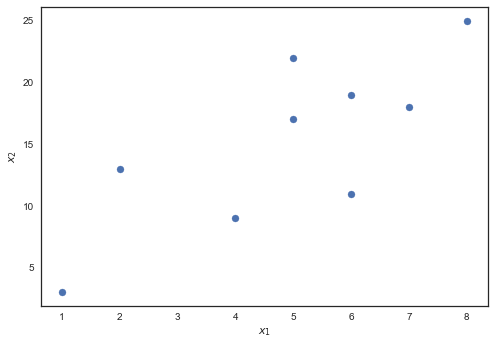

In [3]:
plt.scatter(X[:,0], X[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

#### Question 1. What is the angle between the $x_1$ axis and the vector corresponding to the first principal component for this data (don't forget to rescale the data using StandardScaler)? 
- 30 degrees
- 45 degrees **[+]**
- 60 degrees
- 75 degrees

In [4]:
# Answer
from scipy.linalg import svd

X_scaled = StandardScaler().fit_transform(X)
U, Sigma, VT = svd(X_scaled)
print(VT)

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


#### Question 2. </font> What are the eigenvalues of the $X^{\text{T}}X$ matrix, given $X$ is a rescaled matrix of the toy dataset?

 - 4 and 1.42
 - 16.2 and 2702.8
 - 4.02 and 51.99
 - 15.97 and 2.03 **[+]**

In [5]:
# Answer
np.linalg.eig(X_scaled.T.dot(X_scaled))[0]

array([ 15.96987204,   2.03012796])

#### Question 3. </font> What is the meaning of the two numbers from the previous question?


- their squares tell what part of the initial data's variance is explained by principal components
- they define a rotation angle between the first principal component and the initial axis
- those numbers tell what part of the initial data's variance is explained by principal components **[+]**
- the square roots of those numbers define a rotation angle between the first principal component and the initial axis

Let's load a dataset of peoples' faces and output their names (this step requires reliable and fast internet connection).

In [6]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4, data_home='../../data/faces')

print('%d objects, %d features, %d classes' % (lfw_people.data.shape[0],
      lfw_people.data.shape[1], len(lfw_people.target_names)))
print('\nPersons:')
for name in lfw_people.target_names:
    print(name)

1560 objects, 1850 features, 12 classes

Persons:
Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Jacques Chirac
Jean Chretien
John Ashcroft
Junichiro Koizumi
Serena Williams
Tony Blair


Let's look inside. All images are stored in a handy `lfw_people.images` array.

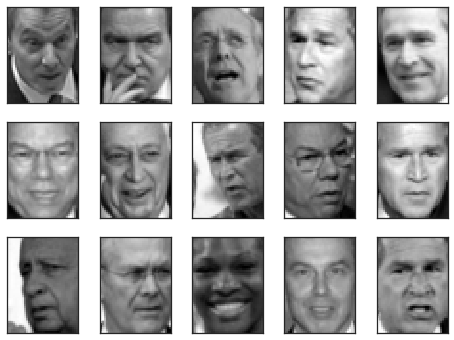

In [7]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='gray')

#### Question 4. </font>What  **minimal** principal component number is needed to explain 90% of data variance (scaled using  StandardScaler)?

- 75
- 76
- 77 **[+]**
- 78

For this task, you should be using the [`svd_solver='randomized'`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) parameter, which is a PCA approximation, but it significantly increases performance on large data sets. Use fixed `random_state=1` for comparable results.

1850 principal components explain 100.00% of variance


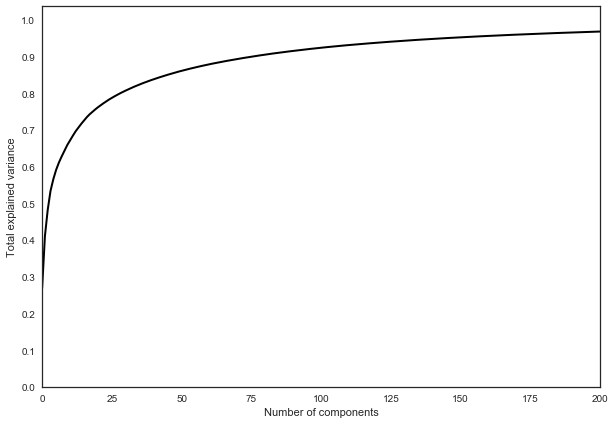

In [8]:
# Answer
pca = PCA(svd_solver='randomized', random_state=1)

scaler = StandardScaler()
faces_scaled = scaler.fit_transform(lfw_people.data)

pca.fit(faces_scaled)

print('%d principal components explain %.2f%% of variance' %
      (pca.n_components_, 100 * np.cumsum(pca.explained_variance_ratio_)[-1]))
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=2, color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [9]:
# Note that np.where returns elemets' indices so the number of principal components is 76+1 = 77
np.where(np.cumsum(pca.explained_variance_ratio_)>0.9)

(array([  76,   77,   78, ..., 1557, 1558, 1559]),)

Print a picture showing the first 30 principal components (don't be scared when you see the result). In order to create it, use 30 vectors from `pca.components_`, reshape them to their initial size (50 x 37) and display.

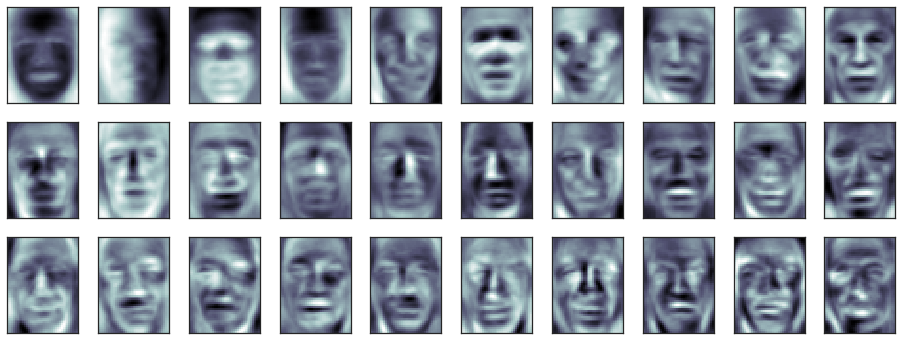

In [10]:
# Answer 
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap='bone')

#### Question 5. </font> Within the first 30 principal components, which one brightens the left side of the face? More specifically, which principal component corresponds to a linear combination of the initial features (pixels' intensity), which, when shown as an image, looks like a photo highlighted from the left side?

- 1
- 2 **[+]**
- 4
- 5

Now let's create a projection of faces into the space of the first two principal components. 

#### Question 6. </font> Who looks the least similar to other person in the dataset if only two first principal components are taken into consideration? 

To answer the question, take two first principal components from rescaled data, evaluate two mean principal components' values for each person over all their images in dataset (again, use both svd_solver='randomized' and random_state=1). Then, having 12 two-dimensional points, find the one which has the largest distance from others (using Euclidean distances). You can do this either precsisely or approximately using `sklearn.metrics.euclidean_distances` and `seaborn.heatmap`.

- Colin Powell
- George W Bush
- Jacques Chirac
- Serena Williams **[+]**

In [11]:
# Answer
lfw_people.target_names, len(lfw_people.target_names)

(array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
        'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
        'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
        'Serena Williams', 'Tony Blair'],
       dtype='<U17'), 12)

In [12]:
pca = PCA(n_components=2, svd_solver='randomized', random_state=1)
pca.fit(faces_scaled)

mean_face_centers = []

for i, name in enumerate(lfw_people.target_names):   
    cloud = pca.transform(faces_scaled[lfw_people.target == i])
    mean_face_centers.append(cloud.mean(axis=0))

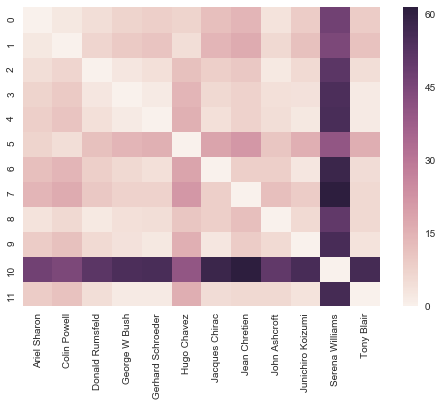

In [13]:
from sklearn.metrics import euclidean_distances

sns.heatmap(euclidean_distances(mean_face_centers))
plt.xticks(np.arange(12) + 0.5, lfw_people.target_names, rotation='vertical');

The answer is Serena Williams.

## 2. Clustering

For the next question load the housing prices dataset:

In [18]:
boston = datasets.load_boston()
X = boston.data

Using elbow-method (see [article 7](https://medium.com/@libfun/db7879568417) of the course) find the optimal number of clusters to set as a hyperparamenter for kMeans algorithm.

#### Question 7. </font> What is the optimal number of clusters for housing prices data set according to elbow-method? Use `random_state=1` in kMeans method, do not rescale the data.

- 2 **[+]**
- 3
- 4
- 5

In this case we are looking for the most significant curve fracture on the `Clusters number vs Centroid distances` graph. Consider the possible number of clusters from 2 to 10. Use `random_state=1` for the kMeans algorithm initialization.

k=2: D(k)=0.325
k=3: D(k)=0.625
k=4: D(k)=0.328
k=5: D(k)=1.018
k=6: D(k)=0.632
k=7: D(k)=0.681
k=8: D(k)=0.907


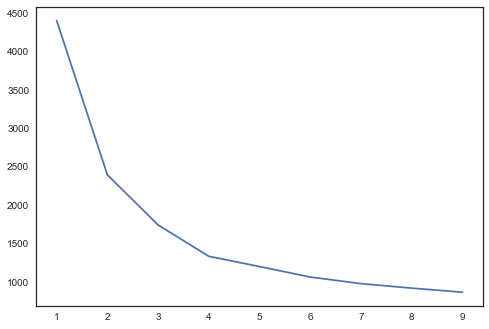

In [19]:
# Answer
func = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    func.append(np.sqrt(kmeans.inertia_))


scores=[]
for i in range(1,8):
    scores.append((func[i]-func[i+1]) / (func[i-1]-func[i]))
    print("k={}: D(k)={}".format(i + 1 , round(scores[i-1], 3)))
plt.plot(range(1, 10), func);

Let's get back to the faces dataset. Imagine we don't know who is shown on which photo, but we know there are 12 different people. Let's compare clustering results of the 4 algorithms - kMeans, Agglomerative clustering, AffinityPropagation and Spectral clustering. Use the algorithms' parameters from the bottom of the [article](https://medium.com/@libfun/db7879568417), simply change number of clusters to 12.

#### Question 8. </font> Select all of the correct statements:

- Agglomerative clustering worked better than others by all metrics
- Clustering results are disappointing - there isn't a metric that exceeds 35% **[+]**
- Affinity Propagation worked better than Spectral clustering by all metrics **[+]**
- Considering only 2 clusters (whether it is Serena Williams or not) and comparing clustering results with a binary vector, we can see that clustering algorithms work better, with some metrics exceeding 66% **[+]**

In [20]:
# Answer
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

algorithms = [KMeans(n_clusters=12, random_state=1),
              AffinityPropagation(),
              SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors'),
              AgglomerativeClustering(n_clusters=12)]

res = []
for algo in algorithms:
    algo.fit(faces_scaled)
    res.append(({
        'ARI': metrics.adjusted_rand_score(lfw_people.target, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(lfw_people.target, algo.labels_),
        'Homogenity': metrics.homogeneity_score(lfw_people.target, algo.labels_),
        'Completeness': metrics.completeness_score(lfw_people.target, algo.labels_),
        'V-measure': metrics.v_measure_score(lfw_people.target, algo.labels_),
        'Silhouette': metrics.silhouette_score(faces_scaled, algo.labels_)}))
    
results = pd.DataFrame(data=res, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['KMeans', 'Affinity', 
                              'Spectral', 'Agglomerative'])

In [21]:
results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
KMeans,0.027093,0.068304,0.095802,0.083819,0.089410,0.044945
Affinity,0.014616,0.086747,0.305615,0.154552,0.205288,0.019190
Spectral,0.011699,0.067703,0.086099,0.094563,0.090133,-0.050495
Agglomerative,0.027382,0.073197,0.099838,0.089044,0.094132,0.025744


In [22]:
# And check the last statement
algorithms2 = [KMeans(n_clusters=2, random_state=1),
              AffinityPropagation(),
              SpectralClustering(n_clusters=2, random_state=1,
                                     affinity='nearest_neighbors'),
              AgglomerativeClustering(n_clusters=2)]

is_serena = (lfw_people.target == 10).astype('int')

res2 = []
for algo in algorithms2:
    algo.fit(faces_scaled)
    res2.append(({
        'ARI': metrics.adjusted_rand_score(is_serena, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(is_serena, algo.labels_),
        'Homogenity': metrics.homogeneity_score(is_serena, algo.labels_),
        'Completeness': metrics.completeness_score(is_serena, algo.labels_),
        'V-measure': metrics.v_measure_score(is_serena, algo.labels_),
        'Silhouette': metrics.silhouette_score(faces_scaled, algo.labels_)}))
    
results2 = pd.DataFrame(data=res2, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['KMeans', 'Affinity', 
                              'Spectral', 'Agglomerative'])
results2

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
KMeans,0.027811,0.042521,0.200508,0.042976,0.070781,0.145569
Affinity,0.001555,0.017287,0.675966,0.023447,0.045322,0.019190
Spectral,0.179523,0.086187,0.288566,0.086801,0.133458,0.142323
Agglomerative,0.026231,0.037344,0.176463,0.037801,0.062264,0.119324


So, all statements are correct except the first one.

Use the coordinates of 12 "average" people's images you got before. Draw a dendrogram for them. Use the `scipy.cluster.hierarchy` and `scipy.spatial.distance.pdist`, take parameters values from the appropriate example in the [article](https://medium.com/@libfun/db7879568417).

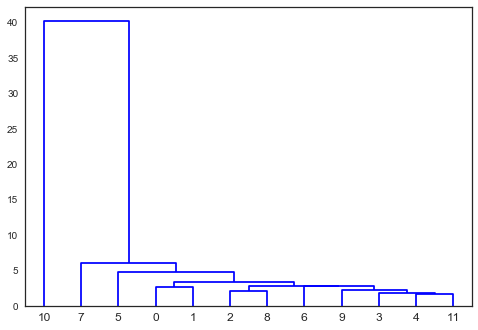

In [23]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

''' Your code is here '''
distance_mat = pdist(mean_face_centers) 

Z = hierarchy.linkage(distance_mat, 'single') 
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

#### Question 9. Look at the dendrogram and consider a step when just two clusters are left: Serena Williams vs. all.  Who was the last person added to the "big" cluster?  

- Gerhard Schroeder
- Jean Chretien **[+]**
- John Ashcroft
- Junichiro Koizumi

In [24]:
# Answer
lfw_people.target_names[7]

'Jean Chretien'